# Customer segmentation
_Jayeeta Ghosh (Aug 2018)_

____
### Explore Customer Dataset
This notebook is meant to be the Exploratory Data Analytis on sample/all customer data for time window 2017/01/29 to 2017/03/30. Goal is to run for one fiscal year once the logic is formalized properly.

### Workflow: 
Number of customer records for 2 months between '2017-01-29' and '2017-03-30 - 1,143,715, though the plan is to go atleast one fiscal year <br />



1. Check duplicates and remove if exists
2. Remove variables that are >90% null, and all constant variables
3. Run plain descriptive statistics
4. Make sure to check if the datatypes are correct, otherwise change into proper types including date, numerical and object type
5. Check unique counts on categorical features and impute missing ones using string "Missing"
6. Make simple bar plots to gather a sense of important ones
7. Get all the numerical columns and create correlation plots and distribution plots
8. Run bivariate analysis
9. Based on distribution - formulate the filtering logic, the customers that should be removed before Clustering 




In [1]:
import sys, os, time
sys.path.append('/mnt/Opaisle/resources/python/')
# sys.path.append('/home/ubuntu/.local/lib/python3.4/site-packages')
sys.path.insert(0, '/home/ubuntu/.local/lib/python3.4/site-packages')
import helper_functions as gp
import pandas as pd

In [2]:
# set display right
pd.set_option('display.width', 4000)
pd.set_option('max_colwidth', 4000)
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 200)

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime#, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
# from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
# import plotly.graph_objs as go
# from plotly.offline import init_notebook_mode,iplot
# init_notebook_mode(connected=True)
# warnings.filterwarnings("ignore")
# plt.rcParams["patch.force_edgecolor"] = True
# plt.style.use('fivethirtyeight')
# mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

%matplotlib inline

In [4]:
# Data directory
DataDir = "Input/"
OutDir = "Output/"

In [5]:
query_list = [
    """
    SELECT  *
    FROM
        dbo.cust_demo
        
    ORDER BY
        customer_key
    
    """
]

In [6]:
%%time
df = gp.dmno_execute(query_list, connection='azure')
# 1.1m data pull took 25min 33s

COMPLETED! 1318.83 seconds.
CPU times: user 22min 35s, sys: 11.7 s, total: 22min 46s
Wall time: 21min 59s


In [9]:
# Save this dataframe for now
# # df.to_csv(DataDir + "ModelingData100K.csv")
df.to_csv(DataDir + "ModelingData1.1M.csv", index=False)

In [6]:
# Just read sample data
# df = pd.read_csv(DataDir +"ModelingData100K.csv")
# df = pd.read_csv(DataDir +"ModelingData1.1M.csv")

In [7]:
print('Dataframe dimensions:', 
df.shape)

Dataframe dimensions: (1146571, 54)


In [8]:
df.head(3)

,Unnamed: 0,customer_key,avg_basket_size,avg_basket_price,count_num_txn,count_num_product,total_sales_amt,count_num_items,min_sales_amt,total_cost_amt,total_diff_sale_cost,total_discount_amt,count_num_return,count_online_ord,count_retail_ord,count_onsale_flag,count_promo_code,avg_daysinto_promo,count_regular_priced,count_markdown_priced,age,mega_age,mega_type_age,gender,nm1_gender,nm1_marital_status,mega_homeowner,mega_type_homeowner,mega_education,mega_type_education,ethnic_code,group_ethnic_code,mega_presence_of_children,mega_type_presence_of_children,mega_number_of_children,mega_type_number_of_children,address_type,mega_income,mega_type_income,adjusted_net_worth,home_value,credit_ranges,new_credit_range,num_credit_lines,bank_card,premium_bank_card,retail_card,upscale_retail_card,social_iq_facebook,social_iq_twitter,mega_fitness_or_exercise,mega_type_fitness_or_exercise,merkle_inf_cardholders_rank,merkle_marketing_index,merkle_marketing_rank,merkle_responder_rating,spoken_language
0,0,376,6,451.000,1,3,902.00,12,38.00,211.28,690.72,-248.06,0,0,12,0,2,9.0,12,0,48.0,48.0,A,F,F,S,Y,A,2.0,A,01,K,Y,A,1.0,A,S,5.0,A,304393.0,Q,C,0.0,0.0,Y,NaN,Y,Y,2.0,6.0,0.0,M,6.0,589.0,9.0,1.0,01
1,1,454,5,307.235,9,10,4657.86,108,0.00,1317.96,3339.90,-930.76,17,99,9,96,5,57.0,6,100,58.0,58.0,A,F,F,NaN,R,A,2.0,A,20,E,N,M,0.0,NaN,H,4.0,A,28480.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,6.0,4.0,1.0,A,2.0,7.0,2.0,0.0,20
2,2,584,7,324.070,1,6,324.07,7,27.65,96.40,227.67,NaN,0,0,7,0,0,NaN,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Percent discount
df['perc_discount'] = 100.0 * (-df['total_discount_amt'])/df['total_sales_amt']

In [11]:
# Keep customers who purchased and got discount within the time window
# and drop other customers who only returned within the time window
df = df[(df['total_discount_amt'] <= 0) & (df['total_sales_amt'] > 0)] 

### 1. Check duplicates and remove if exists

In [12]:
# Check duplicate rows if exists
print('Duplicates: {}'.format(df.duplicated().sum()))

Duplicates: 0


In [13]:
# Remove duplicate rows if exists
print('Dataframe dimensions before:', df.shape)
df.drop_duplicates(inplace = True)
print('Dataframe dimensions after:', df.shape)

Dataframe dimensions before: (792425, 55)
Dataframe dimensions after: (792425, 55)


### 2. Remove variables that are >90% null, and all constant variables


In [14]:
# Drop columns that are >90% null
print('Dataframe dimensions before:', df.shape)
df = df.dropna(thresh=0.1*len(df), axis=1)
print('Dataframe dimensions after:', df.shape)

Dataframe dimensions before: (792425, 55)
Dataframe dimensions after: (792425, 55)


In [12]:
# Lets remove constant columns
df = df.loc[:,df.apply(pd.Series.nunique) != 1]
print('Dataframe dimensions after:', df.shape)

Dataframe dimensions after: (1143715, 53)


### 3. Run plain descriptive statistics


In [15]:
# df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,customer_key,avg_basket_size,avg_basket_price,count_num_txn,count_num_product,total_sales_amt,count_num_items,min_sales_amt,total_cost_amt,total_diff_sale_cost,total_discount_amt,count_num_return,count_online_ord,count_retail_ord,count_onsale_flag,count_promo_code,avg_daysinto_promo,age,mega_age,mega_type_age,gender,nm1_gender,nm1_marital_status,mega_homeowner,mega_type_homeowner,mega_education,mega_type_education,ethnic_code,group_ethnic_code,mega_presence_of_children,mega_type_presence_of_children,mega_number_of_children,mega_type_number_of_children,address_type,mega_income,mega_type_income,adjusted_net_worth,home_value,credit_ranges,new_credit_range,num_credit_lines,bank_card,premium_bank_card,retail_card,upscale_retail_card,social_iq_facebook,social_iq_twitter,mega_fitness_or_exercise,mega_type_fitness_or_exercise,merkle_inf_cardholders_rank,merkle_marketing_index,merkle_marketing_rank,merkle_responder_rating,spoken_language,perc_discount
0,376,12,902.00000,1,3,902.00,12,38.00,211.28,690.72,-248.06,0,0,12,0,2,9.0,48.0,48.0,A,F,F,S,Y,A,2.0,A,01,K,Y,A,1.0,A,S,5.0,A,304393.0,Q,C,0.0,0.0,Y,None,Y,Y,2.0,6.0,0.0,M,6.0,589.0,9.0,1.0,01,27.501109
1,454,9,573.07625,9,10,3020.68,64,0.00,790.76,2229.92,-644.92,10,54,10,48,5,55.0,58.0,58.0,A,F,F,None,R,A,2.0,A,20,E,N,M,0.0,None,H,4.0,A,28480.0,None,None,NaN,NaN,Y,None,None,None,6.0,4.0,1.0,A,2.0,7.0,2.0,0.0,20,21.350160
3,597,6,708.00000,1,1,708.00,6,118.00,187.62,520.38,-125.64,0,6,0,0,3,25.0,0.0,NaN,None,None,None,None,None,None,NaN,None,None,None,None,None,NaN,None,None,NaN,None,NaN,None,None,NaN,NaN,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,17.745763
4,699,6,122.16000,1,3,122.16,6,10.99,51.22,70.94,-12.22,0,0,6,2,1,23.0,39.0,39.0,A,F,F,S,Y,A,3.0,A,21,E,N,A,0.0,None,S,5.0,A,397672.0,R,F,0.0,0.0,Y,None,None,None,6.0,6.0,1.0,A,1.0,23.0,3.0,1.0,01,10.003274
6,766,20,1089.60000,1,2,1089.60,20,49.97,311.10,778.50,-168.98,0,20,0,20,4,166.0,52.0,52.0,A,F,F,M,Y,A,1.0,A,01,K,Y,A,4.0,A,S,4.0,A,261918.0,N,B,0.0,0.0,Y,None,Y,Y,2.0,3.0,1.0,A,10.0,513.0,9.0,4.0,01,15.508443


In [16]:
df.describe()
df.info()
# Get some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792425 entries, 0 to 1146568
Data columns (total 55 columns):
customer_key                      792425 non-null int64
avg_basket_size                   792425 non-null int64
avg_basket_price                  792425 non-null float64
count_num_txn                     792425 non-null int64
count_num_product                 792425 non-null int64
total_sales_amt                   792425 non-null float64
count_num_items                   792425 non-null int64
min_sales_amt                     792425 non-null float64
total_cost_amt                    792425 non-null float64
total_diff_sale_cost              792425 non-null float64
total_discount_amt                792425 non-null float64
count_num_return                  792425 non-null int64
count_online_ord                  792425 non-null int64
count_retail_ord                  792425 non-null int64
count_onsale_flag                 792425 non-null int64
count_promo_code                  79

,customer_key,avg_basket_size,avg_basket_price,count_num_txn,count_num_product,total_sales_amt,count_num_items,min_sales_amt,total_cost_amt,total_diff_sale_cost,total_discount_amt,count_num_return,count_online_ord,count_retail_ord,count_onsale_flag,count_promo_code,avg_daysinto_promo,age,mega_age,mega_type_age,gender,nm1_gender,nm1_marital_status,mega_homeowner,mega_type_homeowner,mega_education,mega_type_education,ethnic_code,group_ethnic_code,mega_presence_of_children,mega_type_presence_of_children,mega_number_of_children,mega_type_number_of_children,address_type,mega_income,mega_type_income,adjusted_net_worth,home_value,credit_ranges,new_credit_range,num_credit_lines,bank_card,premium_bank_card,retail_card,upscale_retail_card,social_iq_facebook,social_iq_twitter,mega_fitness_or_exercise,mega_type_fitness_or_exercise,merkle_inf_cardholders_rank,merkle_marketing_index,merkle_marketing_rank,merkle_responder_rating,spoken_language,perc_discount
column type,int64,int64,float64,int64,int64,float64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,object,object,object,object,object,object,float64,object,object,object,object,object,float64,object,object,float64,object,float64,object,object,float64,float64,object,object,object,object,float64,float64,float64,object,float64,float64,float64,float64,object,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,132965,24627,90083,90083,125513,103503,175224,90083,90083,90083,90083,116517,116517,90083,90083,90083,339745,41491,90083,90083,90083,210431,378796,157865,157865,180961,640314,454938,559221,54513,54513,90083,90083,90083,123385,90083,90083,116517,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.7795,3.1078,11.368,11.368,15.8391,13.0616,22.1124,11.368,11.368,11.368,11.368,14.7039,14.7039,11.368,11.368,11.368,42.8741,5.23595,11.368,11.368,11.368,26.5553,47.8021,19.9218,19.9218,22.8364,80.8044,57.4109,70.5708,6.87926,6.87926,11.368,11.368,11.368,15.5706,11.368,11.368,14.7039,0


In [34]:
# txnCols = ['avg_basket_size', 'avg_basket_price', 'count_num_txn', 'count_num_product', 'total_sales_amt', 'count_num_items', 
#            'min_sales_amt', 'total_cost_amt', 'total_diff_sale_cost', 'total_discount_amt', 'count_num_return', 
#            'count_online_ord', 'count_retail_ord', 'count_onsale_flag', 'count_promo_code', 'avg_daysinto_promo', 
#            'count_regular_priced', 'count_markdown_priced']

# txnColsToAdd = ['avg_basket_price', 'total_sales_amt', 'total_discount_amt', 'count_onsale_flag', 'count_promo_code', 
#                 'count_markdown_priced']

# demoCols = ['age', 'mega_age', 'mega_type_age', 'gender', 'nm1_gender', 'nm1_marital_status', 'mega_homeowner', 
#             'mega_type_homeowner', 'mega_education', 'mega_type_education', 'ethnic_code', 'group_ethnic_code', 
#             'mega_presence_of_children', 'mega_type_presence_of_children', 'mega_number_of_children', 'address_type', 
#             'mega_income', 'mega_type_income', 'adjusted_net_worth', 'home_value', 'credit_ranges', 'new_credit_range', 
#             'num_credit_lines', 'bank_card', 'social_iq_facebook', 'social_iq_twitter', 'mega_fitness_or_exercise', 
#             'mega_type_fitness_or_exercise', 'merkle_inf_cardholders_rank', 'merkle_marketing_index', 'merkle_marketing_rank', 
#             'merkle_responder_rating', 'spoken_language']

# demoColsToAdd = ['gender', 'nm1_marital_status', 'mega_education', 'mega_presence_of_children', 'adjusted_net_worth']

In [16]:
df.dtypes

customer_key                        int64
avg_basket_size                     int64
avg_basket_price                  float64
count_num_txn                       int64
count_num_product                   int64
total_sales_amt                   float64
count_num_items                     int64
min_sales_amt                     float64
total_cost_amt                    float64
total_diff_sale_cost              float64
total_discount_amt                float64
count_num_return                    int64
count_online_ord                    int64
count_retail_ord                    int64
count_onsale_flag                   int64
count_promo_code                    int64
avg_daysinto_promo                float64
count_regular_priced                int64
count_markdown_priced               int64
age                               float64
mega_age                          float64
mega_type_age                      object
gender                             object
nm1_gender                        

### 4. Make sure to check if the datatypes are correct, otherwise change into proper types including date, numerical and object type

In [17]:
# Change a few numerical columns to string
colsToString = ['customer_key', 'mega_education', 'mega_number_of_children', 'mega_income', 'new_credit_range', 'num_credit_lines']
df[colsToString] = df[colsToString].astype(str)

### 5. Check unique counts on categorical features, remove the ones that are less intuitive, and impute missing ones using string "Missing"
Lets explore a few categorical columns. We need to make sure which variables are important for customers

In [18]:
# Consider all categorical columns
catData = df.select_dtypes(include=['object'])
catCol = catData.columns
# print(catCol)
catColToImpute = [item for item in catCol if item not in 
                  ['customer_key', 'transaction_num', 'product_key']]
print(catColToImpute)

['mega_type_age', 'gender', 'nm1_gender', 'nm1_marital_status', 'mega_homeowner', 'mega_type_homeowner', 'mega_education', 'mega_type_education', 'ethnic_code', 'group_ethnic_code', 'mega_presence_of_children', 'mega_type_presence_of_children', 'mega_number_of_children', 'mega_type_number_of_children', 'address_type', 'mega_income', 'mega_type_income', 'home_value', 'credit_ranges', 'new_credit_range', 'num_credit_lines', 'bank_card', 'premium_bank_card', 'retail_card', 'upscale_retail_card', 'mega_type_fitness_or_exercise', 'spoken_language']


In [19]:
df.fillna({x:'Missing' for x in catColToImpute}, inplace=True)

In [20]:
# unique counts
def unique_counts(sample):
   for i in sample.columns:
       count = sample[i].nunique()
       print(i, ": ", count)
unique_counts(df[catColToImpute])

mega_type_age :  3
gender :  4
nm1_gender :  4
nm1_marital_status :  3
mega_homeowner :  3
mega_type_homeowner :  3
mega_education :  5
mega_type_education :  3
ethnic_code :  199
group_ethnic_code :  15
mega_presence_of_children :  3
mega_type_presence_of_children :  3
mega_number_of_children :  10
mega_type_number_of_children :  2
address_type :  9
mega_income :  13
mega_type_income :  3
home_value :  23
credit_ranges :  9
new_credit_range :  9
num_credit_lines :  11
bank_card :  3
premium_bank_card :  2
retail_card :  2
upscale_retail_card :  2
mega_type_fitness_or_exercise :  3
spoken_language :  88


In [21]:
# Lets remove all _type columns before plotting them
typecols = [col for col in df.columns if '_type' in col]

In [26]:
# Categorical columns for plot
catColPlot = [item for item in catColToImpute if item not in typecols + ['nm1_gender', 'ethnic_code',  'group_ethnic_code', 
                                                      'home_value', 'spoken_language']]
print(catColPlot)

['gender', 'nm1_marital_status', 'mega_homeowner', 'mega_education', 'mega_presence_of_children', 'mega_number_of_children', 'mega_income', 'credit_ranges', 'new_credit_range', 'num_credit_lines', 'bank_card', 'premium_bank_card', 'retail_card', 'upscale_retail_card']


In [27]:
# Filter out unknow gender
df = df[df['gender'] != 'U']
df = df[df['nm1_gender'] != 'U']

In [28]:
def cat_graph(graph_title,ss):
    sns.set_style("whitegrid")
    ax = sns.barplot(y="count", x='type', data=ss)
    ax.set(xlabel='', ylabel='', title=graph_title)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.savefig(OutDir + graph_title + '.png')
    plt.show()

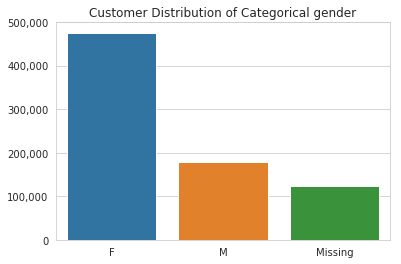

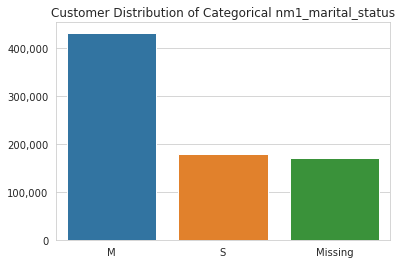

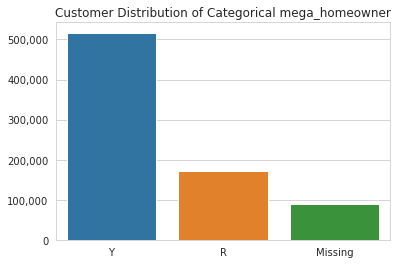

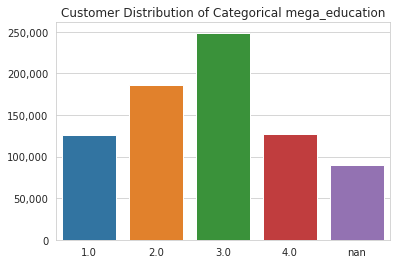

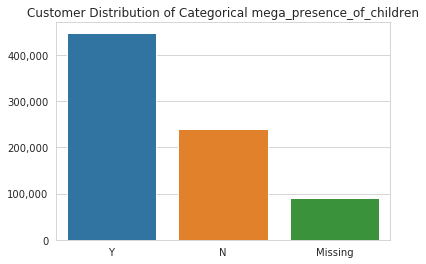

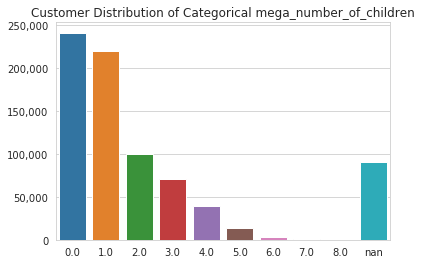

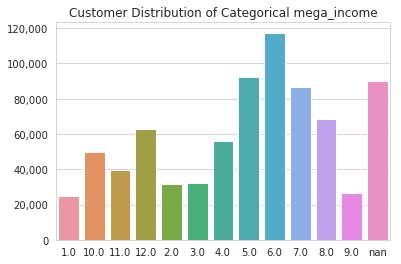

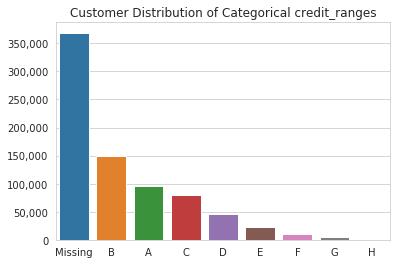

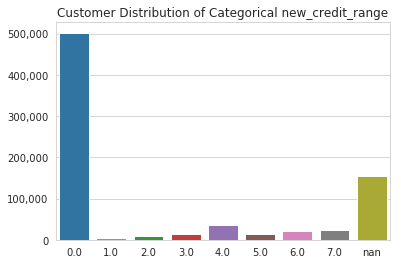

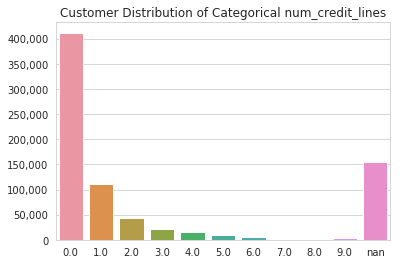

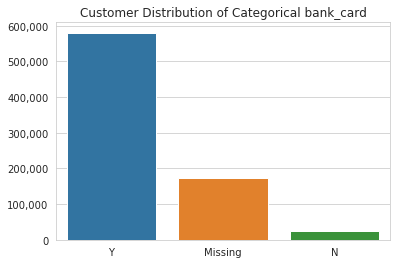

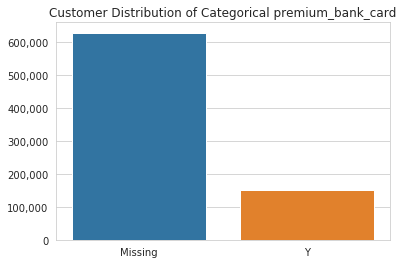

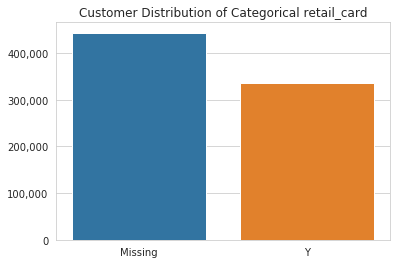

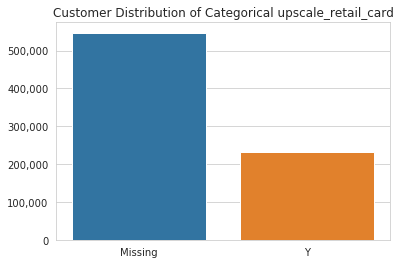

In [29]:
# Plot categorical columns
for c in catColPlot:
    ss = pd.value_counts(df[c]).to_frame().reset_index()
    ss.columns = ['type', 'count']
    graph_name = 'Customer Distribution of Categorical ' + c
    cat_graph(graph_name, ss)

##### Marital status and gender


In [30]:
pd.crosstab(df.nm1_marital_status, df.gender, margins=True)

gender,F,M,Missing,All
nm1_marital_status,,,,
M,315075,100536,16198,431809
Missing,47856,21822,99878,169556
S,112703,56903,8266,177872
All,475634,179261,124342,779237


In [33]:
df.columns

Index(['customer_key', 'avg_basket_size', 'avg_basket_price', 'count_num_txn', 'count_num_product', 'total_sales_amt', 'count_num_items', 'min_sales_amt', 'total_cost_amt', 'total_diff_sale_cost', 'total_discount_amt', 'count_num_return', 'count_online_ord', 'count_retail_ord', 'count_onsale_flag', 'count_promo_code', 'avg_daysinto_promo', 'age', 'mega_age', 'mega_type_age', 'gender', 'nm1_gender', 'nm1_marital_status', 'mega_homeowner', 'mega_type_homeowner', 'mega_education', 'mega_type_education', 'ethnic_code', 'group_ethnic_code', 'mega_presence_of_children', 'mega_type_presence_of_children', 'mega_number_of_children', 'mega_type_number_of_children', 'address_type', 'mega_income', 'mega_type_income', 'adjusted_net_worth', 'home_value', 'credit_ranges', 'new_credit_range', 'num_credit_lines', 'bank_card', 'premium_bank_card', 'retail_card', 'upscale_retail_card', 'social_iq_facebook', 'social_iq_twitter', 'mega_fitness_or_exercise', 'mega_type_fitness_or_exercise', 'merkle_inf_card

/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


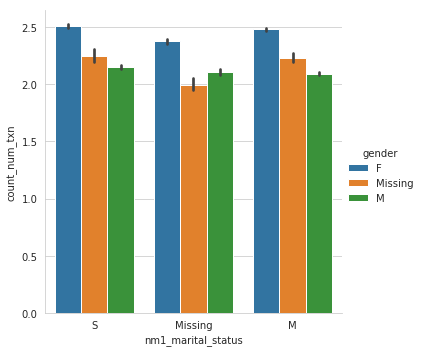

In [37]:
sns.catplot(x="nm1_marital_status", y="count_num_txn", hue="gender", kind="bar", data=df);
plt.savefig(OutDir + 'trans_num_by_gen_marital.png')


/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


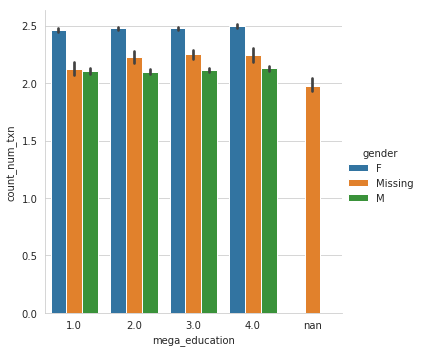

In [38]:
sns.catplot(x="mega_education", y="count_num_txn", hue="gender", kind="bar", data=df);
plt.savefig(OutDir + 'trans_num_by_gen_edu.png')

/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


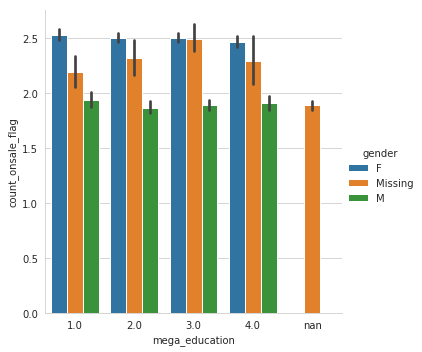

In [39]:
sns.catplot(x="mega_education", y="count_onsale_flag", hue="gender", kind="bar", data=df);
plt.savefig(OutDir + 'onsale_by_gen_edu.png')


/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


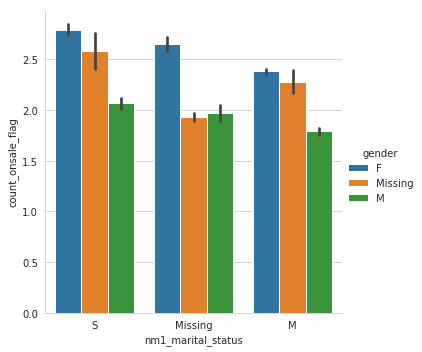

In [40]:
sns.catplot(x="nm1_marital_status", y="count_onsale_flag", hue="gender", kind="bar", data=df);
plt.savefig(OutDir + 'onsale_by_gen_marital.png')


In [26]:
temp = df.groupby(['nm1_marital_status', 'gender']).agg({'total_sales_amt': 'sum'})
# Change: groupby mdse_comp_desc and mdse_div_desc and divide by sum
temp_pcts = temp.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
temp_pcts

total_sales_amt
nm1_marital_status gender                  
M                  F              72.607017
                   M              23.465347
                   Missing         3.399055
                   U               0.528581
Missing            F              30.590874
                   M              14.274574
                   Missing        52.802759
                   U               2.331794
S                  F              61.708094
                   M              32.648550
                   Missing         4.024176
                   U               1.619181

##### Marital status and children

In [41]:
pd.crosstab(df.nm1_marital_status, df.mega_presence_of_children, margins=True)

mega_presence_of_children,Missing,N,Y,All
nm1_marital_status,,,,
M,0,92228,339581,431809
Missing,90083,58746,20727,169556
S,0,89925,87947,177872
All,90083,240899,448255,779237


In [42]:
temp = df.groupby(['nm1_marital_status', 'mega_presence_of_children']).agg({'total_sales_amt': 'sum'})
# Change: groupby mdse_comp_desc and mdse_div_desc and divide by sum
temp_pcts = temp.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
temp_pcts

total_sales_amt
nm1_marital_status mega_presence_of_children                 
M                  N                                21.037301
                   Y                                78.962699
Missing            Missing                          49.434822
                   N                                37.292155
                   Y                                13.273023
S                  N                                50.394231
                   Y                                49.605769

#### Gender and education
| code   | meaning         
| ------------- |:-------------:
| MV012 - 1     | High School 
| MV012 - 2     | Some College      
| MV012 - 3     | Completed College 
| MV012 - 4     | Graduate School     



In [43]:
pd.crosstab(df.gender, df.mega_education, margins=True)

mega_education,1.0,2.0,3.0,4.0,nan,All
gender,,,,,,
F,89379,129109,169990,87156,0,475634
M,30817,47657,65579,35208,0,179261
Missing,6268,9855,13375,4761,90083,124342
All,126464,186621,248944,127125,90083,779237


In [44]:
temp = df.groupby(['gender', 'mega_education']).agg({'total_sales_amt': 'sum'})
# Change: groupby mdse_comp_desc and mdse_div_desc and divide by sum
temp_pcts = temp.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
temp_pcts

total_sales_amt
gender  mega_education                 
F       1.0                   18.271276
        2.0                   27.354750
        3.0                   35.706657
        4.0                   18.667316
M       1.0                   16.684810
        2.0                   26.837852
        3.0                   36.720006
        4.0                   19.757332
Missing 1.0                    5.079530
        2.0                    8.520104
        3.0                   11.675459
        4.0                    4.112723
        nan                   70.612184

### Gender and Homeowner
MV006	R	Renter

MV006	Y	Homeowner

In [45]:
pd.crosstab(df.gender, df.mega_homeowner, margins=True)

mega_homeowner,Missing,R,Y,All
gender,,,,
F,0,105618,370016,475634
M,0,52200,127061,179261
Missing,90083,14496,19763,124342
All,90083,172314,516840,779237


### Gender and Income
MV002	01	<$15,000 <br />
MV002	02	$15,000-$24,999 <br />
MV002	03	$25,000-$34,999 <br />
MV002	04	$35,000-$49,999 <br />
MV002	05	$50,000-$74,999
MV002	06	$75,000-$99,999
MV002	07	$100,000-$124,999
MV002	08	$125,000-$149,999
MV002	09	$150,000-$174,999
MV002	10	$175,000-$199,999
MV002	11	$200,000-$249,999
MV002	12	$250,000+

In [46]:
pd.crosstab(df.gender, df.mega_income, margins=True)

mega_income,1.0,10.0,11.0,12.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,nan,All
gender,,,,,,,,,,,,,,
F,15647,35647,29251,46057,20826,20591,34174,60652,82803,60680,50550,18756,0,475634
M,7679,12231,9014,14751,8847,9258,16653,25984,29565,22679,15563,7037,0,179261
Missing,1712,1751,1418,2317,1939,2395,5059,5488,5094,3593,2468,1025,90083,124342
All,25038,49629,39683,63125,31612,32244,55886,92124,117462,86952,68581,26818,90083,779237


In [47]:
temp = df.groupby(['gender', 'mega_income']).agg({'total_sales_amt': 'sum'})
# Change: groupby mdse_comp_desc and mdse_div_desc and divide by sum
temp_pcts = temp.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
temp_pcts

total_sales_amt
gender  mega_income                 
F       1.0                 3.143273
        10.0                7.811126
        11.0                6.254156
        12.0               10.287178
        2.0                 4.266037
        3.0                 4.132003
        4.0                 6.760172
        5.0                12.312773
        6.0                17.269315
        7.0                12.826258
        8.0                10.981280
        9.0                 3.956428
M       1.0                 4.185165
        10.0                7.123635
        11.0                5.131940
        12.0                8.597848
        2.0                 4.599390
        3.0                 5.042149
        4.0                 8.880231
        5.0                14.448189
        6.0                16.426706
        7.0                12.681235
        8.0                 8.857599
        9.0                 4.025915
Missing 1.0                 1.340645
        10.0                1.531098
        11.0                1.196384
        12.0                2.196196
        2.0                 1.606478
        3.0                 1.930160
        4.0                 4.275216
        5.0                 4.726639
        6.0                 4.400933
        7.0                 3.098188
        8.0                 2.208670
        9.0                 0.877211
        nan                70.612184

### TODO: Create age bin and plot binary distribution of gender and age
create histogram of age and then gender-age

### 7. Get all the numerical columns and create correlation plot

In [48]:
# Get all the numeric columns
numerics = ['float64', 'int32', 'int64']
numData = df.select_dtypes(include=numerics)
numCol = numData.columns
print(numCol)

Index(['avg_basket_size', 'avg_basket_price', 'count_num_txn', 'count_num_product', 'total_sales_amt', 'count_num_items', 'min_sales_amt', 'total_cost_amt', 'total_diff_sale_cost', 'total_discount_amt', 'count_num_return', 'count_online_ord', 'count_retail_ord', 'count_onsale_flag', 'count_promo_code', 'avg_daysinto_promo', 'age', 'mega_age', 'adjusted_net_worth', 'social_iq_facebook', 'social_iq_twitter', 'mega_fitness_or_exercise', 'merkle_inf_cardholders_rank', 'merkle_marketing_index', 'merkle_marketing_rank', 'merkle_responder_rating', 'perc_discount'], dtype='object')


In [49]:
# Imputation - with 0 (discount_amt, any other cont. variables)
df.fillna({x:0 for x in numCol}, inplace=True) 
# df.fillna({x:0 for x in ['discount_amt']}, inplace=True) 

In [50]:
# Get some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,customer_key,avg_basket_size,avg_basket_price,count_num_txn,count_num_product,total_sales_amt,count_num_items,min_sales_amt,total_cost_amt,total_diff_sale_cost,total_discount_amt,count_num_return,count_online_ord,count_retail_ord,count_onsale_flag,count_promo_code,avg_daysinto_promo,age,mega_age,mega_type_age,gender,nm1_gender,nm1_marital_status,mega_homeowner,mega_type_homeowner,mega_education,mega_type_education,ethnic_code,group_ethnic_code,mega_presence_of_children,mega_type_presence_of_children,mega_number_of_children,mega_type_number_of_children,address_type,mega_income,mega_type_income,adjusted_net_worth,home_value,credit_ranges,new_credit_range,num_credit_lines,bank_card,premium_bank_card,retail_card,upscale_retail_card,social_iq_facebook,social_iq_twitter,mega_fitness_or_exercise,mega_type_fitness_or_exercise,merkle_inf_cardholders_rank,merkle_marketing_index,merkle_marketing_rank,merkle_responder_rating,spoken_language,perc_discount
column type,object,int64,float64,int64,int64,float64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,float64,float64,float64,object,float64,float64,float64,float64,object,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
# Numerical columns for plot
numColPlot = [item for item in numCol if item not in ['min_sales_amt', 'social_iq_facebook', 'social_iq_twitter', 
                                                      'mega_fitness_or_exercise', 'merkle_inf_cardholders_rank', 
                                                      'merkle_marketing_index', 'merkle_marketing_rank', 
                                                      'merkle_responder_rating']]
print(numColPlot)

['avg_basket_size', 'avg_basket_price', 'count_num_txn', 'count_num_product', 'total_sales_amt', 'count_num_items', 'total_cost_amt', 'total_diff_sale_cost', 'total_discount_amt', 'count_num_return', 'count_online_ord', 'count_retail_ord', 'count_onsale_flag', 'count_promo_code', 'avg_daysinto_promo', 'age', 'mega_age', 'adjusted_net_worth', 'perc_discount']


In [52]:
def num_graph(graph_title,ss):
    sns.distplot(ss)
    plt.savefig(OutDir + graph_title + '.png')
    plt.show()

/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


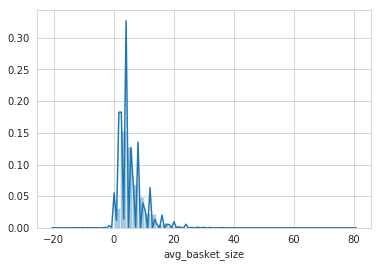

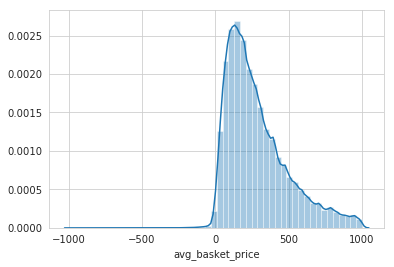

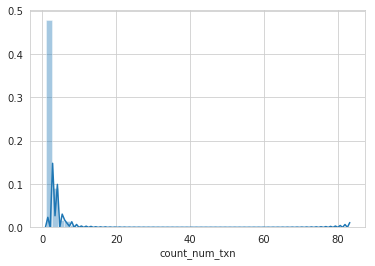

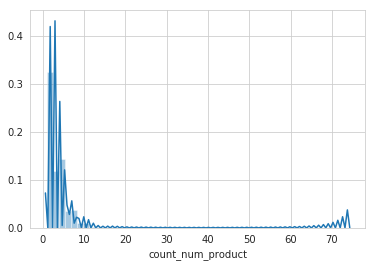

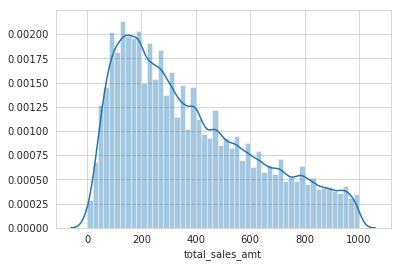

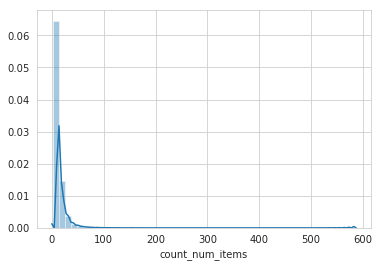

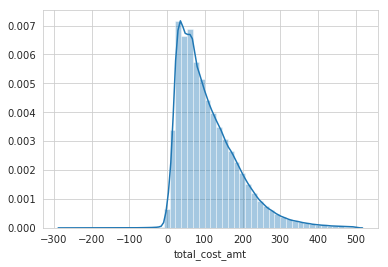

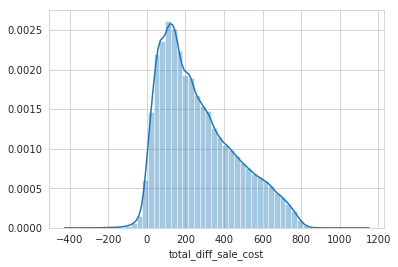

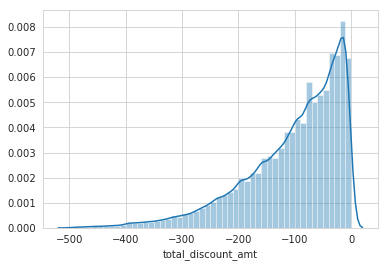

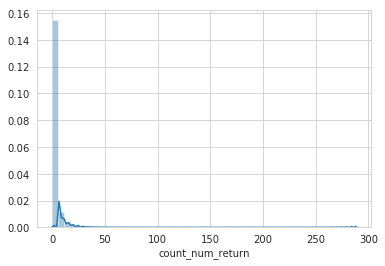

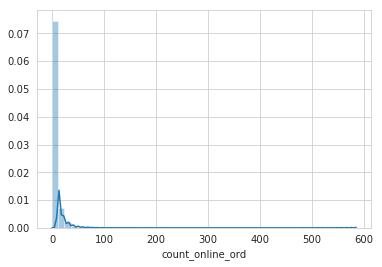

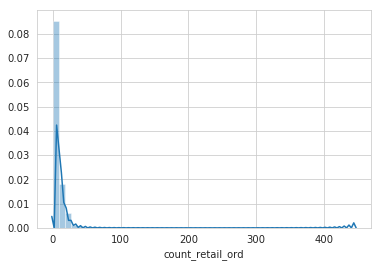

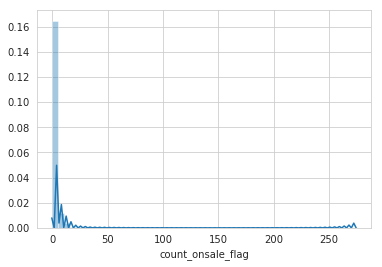

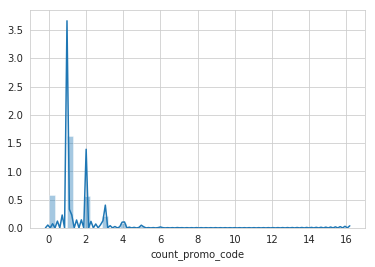

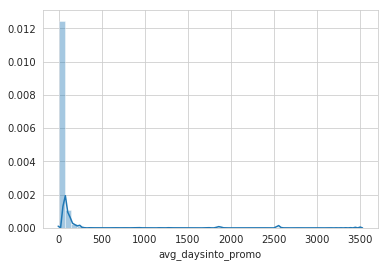

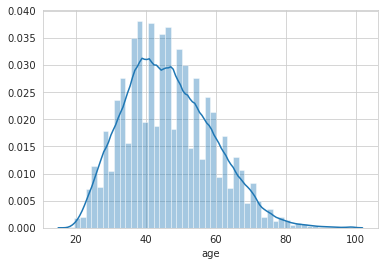

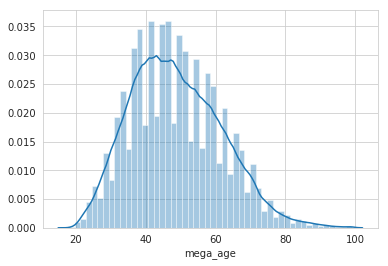

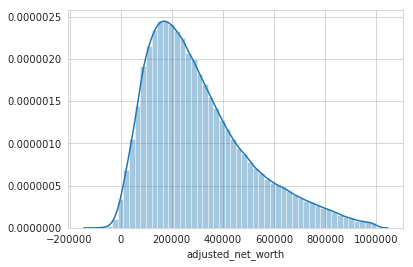

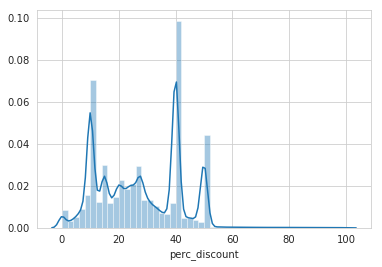

In [58]:
# Plot distribution of numerical features
for c in numColPlot:
    ss = df[c]
    graph_name = 'Customer Distribution_' + c
    num_graph(graph_name, ss)

In [55]:
def cap_vars(df, var):
    ulimit = np.percentile(df[var],99)
    llimit = np.percentile(df[var],1)
#     print(df[var].describe())
    print("Upper limit and lower limit for",var,":", ulimit, "and", llimit)

    df[var].ix[df[var]>ulimit] = ulimit
    df[var].ix[df[var]<llimit] = llimit
#     print(df[var].describe())
    

In [56]:
def filter_vars(df, var, cutoff):
    print('var', var, 'cutoff', cutoff)
    if (var == 'age'):
        df2 = df[df['age']>=18]
    else:
        df2 = df[(abs(df[var]) < cutoff)]
    return df2
 

In [57]:
varHandleChoice = "filter" # "raw", "filter"
if varHandleChoice == "cap":
    print("Cap the values to 99th percentiles")
    for c in numCol:
        cap_vars(df, c)
elif varHandleChoice == "filter":
    print("Filter out rows with skewed data")
    for c in numCol:
        if c == 'avg_basket_price':
            cutoff = 1000
        elif c == 'total_sales_amt':
            cutoff = 1000
        elif c == 'total_cost_amt':
            cutoff = 500
        elif c == 'perc_discount':
            cutoff = 100
        elif c == 'total_discount_amt':
            cutoff = 500
        elif c == 'adjusted_net_worth':
            cutoff = 1000000
        elif c == 'age':
            cutoff = 18
        else:
            cutoff = 10000
#         print("column", c, "cutoff", cutoff)
        df = filter_vars(df, c, cutoff)
else:
    print("Do nothing, just use raw values")
    # Do nothing, use raw values

Filter out rows with skewed data
var avg_basket_size cutoff 10000
var avg_basket_price cutoff 1000
var count_num_txn cutoff 10000
var count_num_product cutoff 10000
var total_sales_amt cutoff 1000
var count_num_items cutoff 10000
var min_sales_amt cutoff 10000
var total_cost_amt cutoff 500
var total_diff_sale_cost cutoff 10000
var total_discount_amt cutoff 500
var count_num_return cutoff 10000
var count_online_ord cutoff 10000
var count_retail_ord cutoff 10000
var count_onsale_flag cutoff 10000
var count_promo_code cutoff 10000
var avg_daysinto_promo cutoff 10000
var age cutoff 18
var mega_age cutoff 10000
var adjusted_net_worth cutoff 1000000
var social_iq_facebook cutoff 10000
var social_iq_twitter cutoff 10000
var mega_fitness_or_exercise cutoff 10000
var merkle_inf_cardholders_rank cutoff 10000
var merkle_marketing_index cutoff 10000
var merkle_marketing_rank cutoff 10000
var merkle_responder_rating cutoff 10000
var perc_discount cutoff 100


In [ ]:
# df['perc_discount'] = 100.0 * (-df['total_discount_amt'])/df['total_sales_amt']
# # Remove customers who only had returned transactions within the time window
# df = df[(df['total_discount_amt'] <= 0) & (df['total_sales_amt'] > 0)] 

In [61]:
colBiPlot = [item for item in numColPlot if item not in ['avg_basket_size',  
                                                         'count_num_txn', 'count_num_product', 
                                                         'count_num_items', 
                                                         'total_cost_amt', 'total_diff_sale_cost', 
                                                         'total_discount_amt', 'count_num_return', 
                                                         'count_online_ord', 'count_retail_ord', 
                                                         'count_promo_code', 
                                                         'avg_daysinto_promo', 'count_regular_priced', 
                                                         'count_markdown_priced', 'mega_age']]
print(colBiPlot)

['avg_basket_price', 'total_sales_amt', 'count_onsale_flag', 'age', 'adjusted_net_worth', 'perc_discount']


In [ ]:
# def bivariate_graph(graph_title,col1, col2):
#     with sns.axes_style('white'):
#     sns.jointplot("age", "adjusted_net_worth", df, kind='hex')
#     sns.distplot(ss)
#     plt.savefig(OutDir + graph_title + '.png')
#     plt.show()

In [ ]:
# # Plot bi plot of numerical features
# for c in colBiPlot:
#     ss = df[c]
#     graph_name = 'Bi-Distribution_' + c
#     bivariate_graph(graph_name, col1, col2)

/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


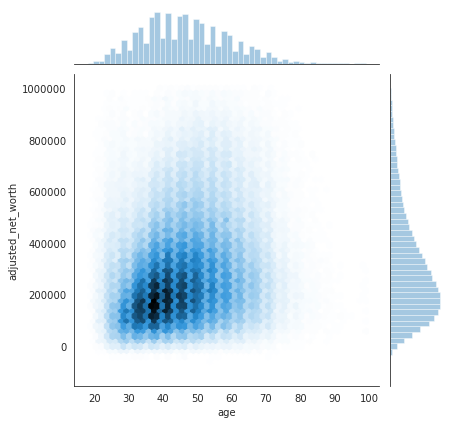

In [64]:
with sns.axes_style('white'):
    sns.jointplot("age", "adjusted_net_worth", df, kind='hex')
plt.savefig(OutDir + 'age_adjusted_net_worth.png')


/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


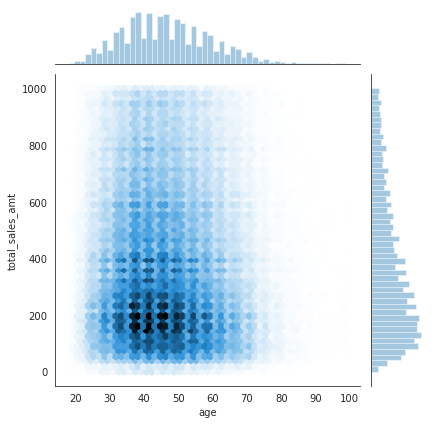

In [65]:
with sns.axes_style('white'):
    sns.jointplot("age", "total_sales_amt", df, kind='hex')
plt.savefig(OutDir + 'age_total_sales_amt.png')


In [67]:
df.columns

Index(['customer_key', 'avg_basket_size', 'avg_basket_price', 'count_num_txn', 'count_num_product', 'total_sales_amt', 'count_num_items', 'min_sales_amt', 'total_cost_amt', 'total_diff_sale_cost', 'total_discount_amt', 'count_num_return', 'count_online_ord', 'count_retail_ord', 'count_onsale_flag', 'count_promo_code', 'avg_daysinto_promo', 'age', 'mega_age', 'mega_type_age', 'gender', 'nm1_gender', 'nm1_marital_status', 'mega_homeowner', 'mega_type_homeowner', 'mega_education', 'mega_type_education', 'ethnic_code', 'group_ethnic_code', 'mega_presence_of_children', 'mega_type_presence_of_children', 'mega_number_of_children', 'mega_type_number_of_children', 'address_type', 'mega_income', 'mega_type_income', 'adjusted_net_worth', 'home_value', 'credit_ranges', 'new_credit_range', 'num_credit_lines', 'bank_card', 'premium_bank_card', 'retail_card', 'upscale_retail_card', 'social_iq_facebook', 'social_iq_twitter', 'mega_fitness_or_exercise', 'mega_type_fitness_or_exercise', 'merkle_inf_card

In [72]:
df = df[df['gender'] != "Missing"]

/usr/local/lib/python3.4/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


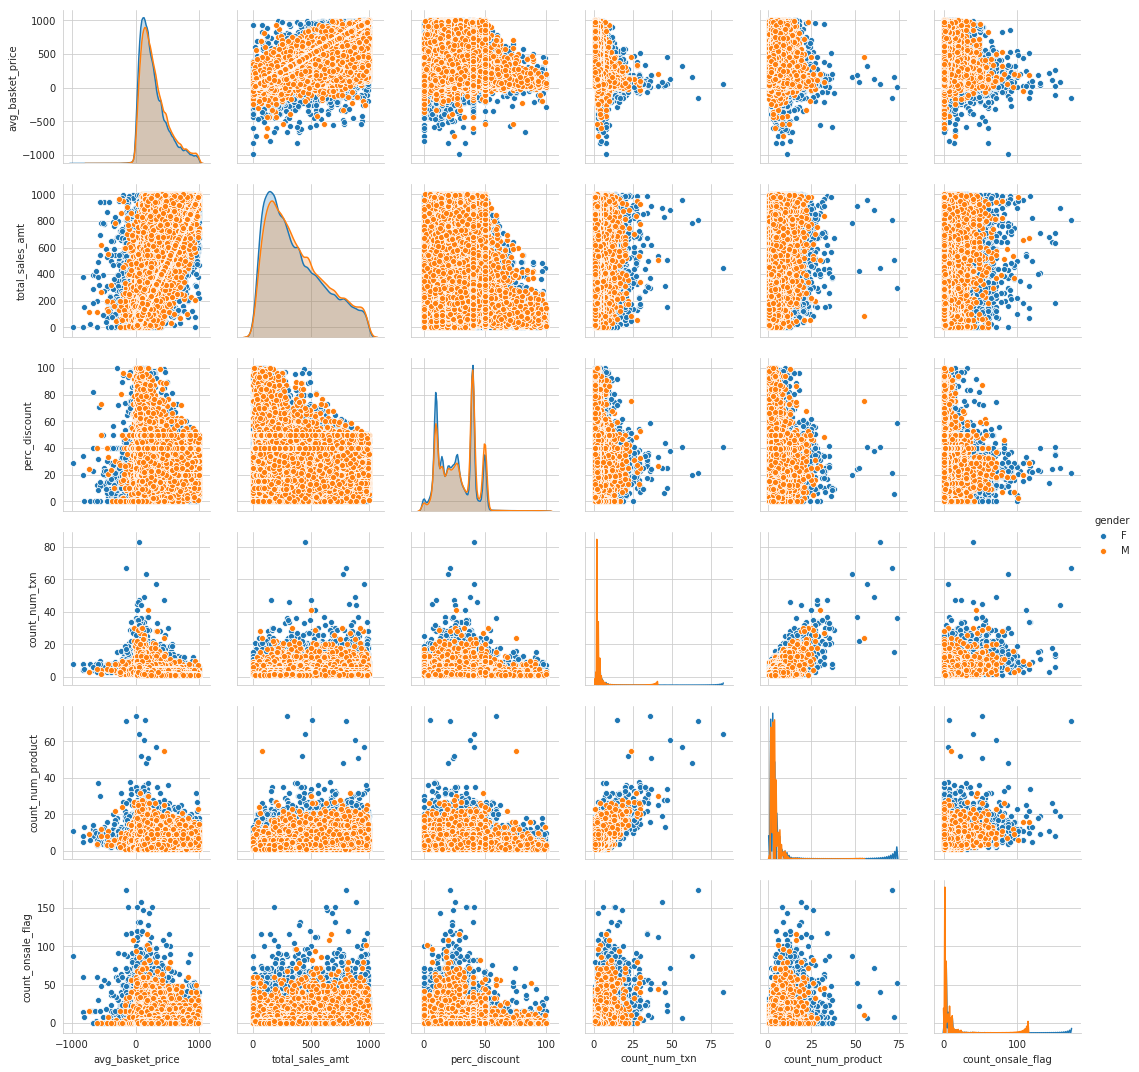

In [73]:
dfplot = df[[ 'avg_basket_price', 'total_sales_amt', 'perc_discount', 'count_num_txn', 
             'count_num_product', 'count_onsale_flag', 'gender']]
sns.pairplot(dfplot, hue='gender', size=2.5);
plt.savefig(OutDir + 'pairplot.png')


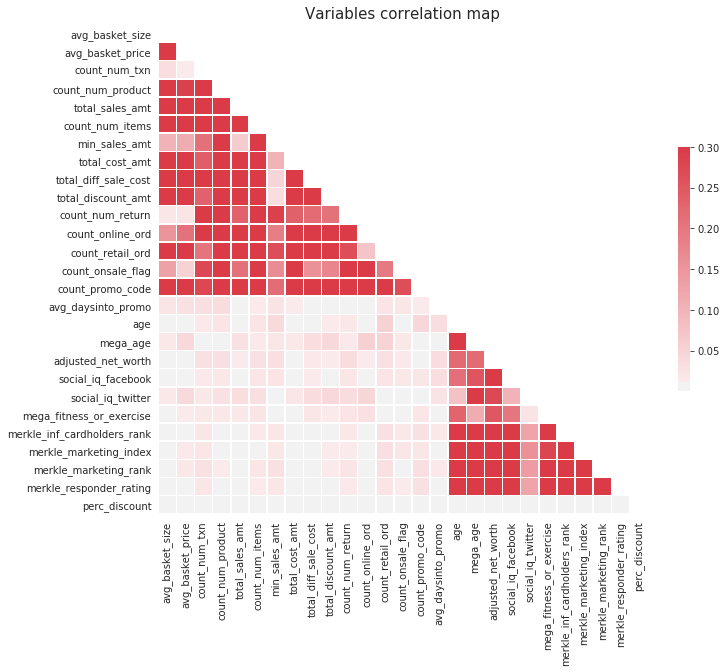

In [71]:
# Get correlation between the numerical columns
corr = abs(numData.corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Variables correlation map", fontsize=15)
graph_title = "customer_correlation"
plt.savefig(OutDir + graph_title + '.png')
plt.show()

# Finished EDA for now

### TODO: Create histogram of age, basket price, total sales etc - all

### TODO: Create binary distribution plot - gender-age, gender-total sales, education-age etc

In [51]:
df['age'].describe()

count    659438.000000
mean         46.268096
std          12.546425
min          18.000000
25%          37.000000
50%          45.000000
75%          55.000000
max          99.000000
Name: age, dtype: float64

In [ ]:
# Lets take a look at the target variable - cap lower and upper boundary
# ulimit = np.percentile(dataset['logerror'],99)
# llimit = np.percentile(dataset['logerror'],1)
# dataset['logerror'].ix[dataset['logerror']>ulimit] = ulimit
# dataset['logerror'].ix[dataset['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(df['total_sales_amt'], bins=5, kde=False)
plt.xlabel('age', fontsize=12)
# sns.plt.savefig(OutDir + 'logerror.png')
plt.show()# normal distribution


In [ ]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df['total_sales_amt'], y=df['age'])
plt.xlabel('Total sales', fontsize=12)
plt.ylabel('Age', fontsize=12)
# sns.plt.savefig(OutDir + 'Error_yearbuilt.png')
plt.show()